試用現有資料 和SIRD模型 
找出不隨時間變化的參數 
感染率beta 
復原率 gamma
死亡率 mu

In [1]:
import requests
import pandas as pd
import torch.optim as optim
import numpy as np

#收集從1月27日到九月中的資料
DATA=[]


將每個月分的資料以月為單位讀入

In [2]:
for i in range(27,32):
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/01-'+str(i)+'-2020.csv'
  res = requests.get(url, allow_redirects=True)
  with open('covid.csv','wb') as file:
     file.write(res.content)
  DATA.append(pd.read_csv('covid.csv'))

In [3]:
for i in range(1,30):
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/02-'+str(i)+'-2020.csv'
  res = requests.get(url, allow_redirects=True)
  with open('covid.csv','wb') as file:
     file.write(res.content)
  DATA.append(pd.read_csv('covid.csv'))

In [4]:
for i in range(1,32):
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/03-'+str(i)+'-2020.csv'
  res = requests.get(url, allow_redirects=True)
  with open('covid.csv','wb') as file:
     file.write(res.content)
  DATA.append(pd.read_csv('covid.csv'))

In [5]:
for i in range(1,31):
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-'+str(i)+'-2020.csv'
  res = requests.get(url, allow_redirects=True)
  with open('covid.csv','wb') as file:
     file.write(res.content)
  DATA.append(pd.read_csv('covid.csv'))

In [6]:
for i in range(1,32):
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/05-'+str(i)+'-2020.csv'
  res = requests.get(url, allow_redirects=True)
  with open('covid.csv','wb') as file:
     file.write(res.content)
  DATA.append(pd.read_csv('covid.csv'))

In [7]:
for i in range(1,31):
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/06-'+str(i)+'-2020.csv'
  res = requests.get(url, allow_redirects=True)
  with open('covid.csv','wb') as file:
     file.write(res.content)
  DATA.append(pd.read_csv('covid.csv'))

In [8]:
for i in range(1,32):
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/07-'+str(i)+'-2020.csv'
  res = requests.get(url, allow_redirects=True)
  with open('covid.csv','wb') as file:
     file.write(res.content)
  DATA.append(pd.read_csv('covid.csv'))

In [9]:
for i in range(1,32):
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/08-'+str(i)+'-2020.csv'
  res = requests.get(url, allow_redirects=True)
  with open('covid.csv','wb') as file:
     file.write(res.content)
  DATA.append(pd.read_csv('covid.csv'))

In [10]:
for i in range(1,31):
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/09-'+str(i)+'-2020.csv'
  res = requests.get(url, allow_redirects=True)
  with open('covid.csv','wb') as file:
     file.write(res.content)
  DATA.append(pd.read_csv('covid.csv'))

實際的執行結果放在最底下，接下來內容是分段敘述各步驟內容


取出特定國家的資料

In [11]:
def Data_of_Country(num): 
  Data_Country=[]
  for i in range(len(DATA)):
    if 'Country/Region' in DATA[i]:
      fliter = (DATA[i]['Country/Region']==Country[num])
      if len(DATA[i][fliter])>0:
        Data_Country.append(DATA[i][fliter])
    elif 'Country_Region' in DATA[i]:
      fliter = (DATA[i]['Country_Region']==Country[num])
      if len(DATA[i][fliter])>0:
        Data_Country.append(DATA[i][fliter])
  return Data_Country

取得每天的 S(疑似) I(感染) R(復原) D(死亡) 資料

In [12]:
def take_SIRD_data(Data_Country,number):
  num_of_Data_Country=len(Data_Country)
  N=population_N[number]
  St=[]
  for i in range(num_of_Data_Country):
    St.append(N-Data_Country[i]['Confirmed'].sum()-Data_Country[i]['Deaths'].sum()-Data_Country[i]['Recovered'].sum())
  St=np.array(St)
  It=[]
  for i in range(num_of_Data_Country):
    It.append(Data_Country[i]['Confirmed'].sum())
  It=np.array(It)
  Rt=[]
  for i in range(num_of_Data_Country):
    Rt.append(Data_Country[i]['Recovered'].sum())
  Rt=np.array(Rt)
  Dt=[]
  for i in range(num_of_Data_Country):
    Dt.append(Data_Country[i]['Deaths'].sum())
  Dt=np.array(Dt)

  return St,It,Rt,Dt

最小化loss function


In [13]:
import numpy as np
from scipy.optimize import minimize

def objective(x):

  #參數 dt 單位天數
  dt=1
  eps=0.0000001
  beta=x[0]
  gamma=x[1]
  mu=x[2]
  
  #藉由finite difference method 做出下一個時間點的預測

  St_pred=St_now*(1-dt*beta*It_now/N)
  It_pred=It_now*(1+dt*(beta*St_now/N)-dt*(mu+gamma))
  Rt_pred=Rt_now+(dt*gamma*It_now)
  Dt_pred=Dt_now+(dt*mu*It_now)
  
  # loss function 只取用論文中使用的loss function的前兩項
  loss=0.01*np.log(np.max(It))/np.max(It)*((It_true-It_pred)**2).sum()+((np.log(It_true+eps)-np.log(It_pred+eps))**2).sum()+0.01*np.log(np.max(It))/np.max(It)*((Dt_true-Dt_pred)**2).sum()+((np.log(Dt_true+eps)-np.log(Dt_pred+eps))**2).sum()                                                                                                                   
  return loss


In [14]:
def find_parameter(num):
  # initial guesses
  beta = 0.01
  gamma = 0.01
  mu = 0.005
  population_N[num]

  x0 = np.zeros(3)
  x0[0] = beta
  x0[1] = gamma
  x0[2] = mu
  b = (0.0,1.0)
  bnds = (b, b, b)

  Sol=minimize(objective,x0,bounds=bnds)
  return Sol.x

預測結果


In [15]:
def predict(beta,gamma,mu,N):
  dt=1
  St_pred=St_now*(1-dt*beta*It_now/N)
  It_pred=It_now*(1+dt*(beta*St_now/N)-(mu+gamma))
  Rt_pred=Rt_now+(dt*gamma*It_now)
  Dt_pred=Dt_now+(dt*mu*It_now)
  return St_pred,It_pred,Rt_pred,Dt_pred

實際計算結果

In [16]:
#國家人口數據
Country=['Italy','Germany','United Kingdom','Spain','US','France','China','Belgium','Egypt','Kenya']
population_N=[60.36*1000000, 83.02*1000000 ,66.56*1000000 ,46.94*1000000 ,327.2*1000000 ,66.99*1000000, 1386*1000000 ,11.46*1000000,10*1000000,4.8*1000000]

In [39]:
#Country中國家的編號
number=9
#def result(number):
beta = 0.3
gamma = 0.01
mu = 0.001
St_preds=[]
It_preds=[]
Rt_preds=[]
Dt_preds=[]
BETA=[]
Gamma=[]
Mu=[]

  # 取某國家資料
Data_Country=Data_of_Country(number)
[St,It,Rt,Dt]=take_SIRD_data(Data_Country,number)
N=population_N[number]
  #第一天
St_now=St[0]
It_now=It[0]
Dt_now=Dt[0]
Rt_now=Rt[0]
dt=1
  #天數
Nday=len(St)-1
  #計算每天的SIDR各項人數 及 參數

  
for i in range(Nday):
    
  St_pred=(St_now*(1-dt*beta*It_now/N))
  It_pred=It_now*(1+dt*(beta*St_now/N)-dt*(mu+gamma))
  Rt_pred=Rt_now+(dt*gamma*It_now)
  Dt_pred=Dt_now+(dt*mu*It_now)

  St_true=St[i+1]
  It_true=It[i+1]
  Rt_true=Rt[i+1]
  Dt_true=Dt[i+1]
  [beta,gamma,mu]=find_parameter(number)
  [St_pred,It_pred,Rt_pred,Dt_pred]=predict(beta,gamma,mu,N)

  St_preds.append(St_pred)
  It_preds.append(It_pred)
  Rt_preds.append(Rt_pred)
  Dt_preds.append(Dt_pred)
  BETA.append(beta)
  Gamma.append(gamma)
  Mu.append(mu)

  St_now=St_pred
  It_now=It_pred
  Rt_now=Rt_pred
  Dt_now=Dt_pred
  
St_preds=np.array(St_preds)
It_preds=np.array(It_preds)
Rt_preds=np.array(Rt_preds)
Dt_preds=np.array(Dt_preds)

  #return Dt_preds#,It_preds,Rt_preds,Dt_preds,BETA,Gamma,Mu

In [40]:
#Italy_beta=BETA
#Italy_gamma=Gamma
#Italy_mu=Mu


#Germany_beta=BETA
#Germany_gamma=Gamma
#Germany_mu=Mu


#UK_beta=BETA
#UK_gamma=Gamma
#UK_mu=Mu


#Spain_beta=BETA
#Spain_gamma=Gamma
#Spain_mu=Mu

#US_beta=BETA
#US_gamma=Gamma
#US_mu=Mu

#France_beta=BETA
#France_gamma=Gamma
#France_mu=Mu

#China_beta=BETA
#China_gamma=Gamma
#China_mu=Mu

#Belgium_beta=BETA
#Belgium_gamma=Gamma
#Belgium_mu=Mu

#Egypt_beta=BETA
#Egypt_gamma=Gamma
#Egypt_mu=Mu

Kenya_beta=BETA
Kenya_gamma=Gamma
Kenya_mu=Mu


註 下圖藍線為model預測結果 橘線為實際資料 因為人數已千或萬人為單位，所以看不太出人數的差別。
故，另外計算實際最大誤差人數

最大誤差 1.7083297190531467e-05


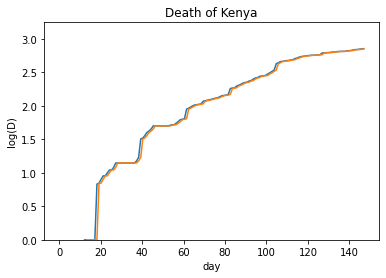

In [41]:
import matplotlib.pyplot as plt
eps=0.00001
dat=np.linspace(0,len(Dt)-1,len(Dt)-1)

plt.plot(dat,np.log10(Dt_preds+eps)) #預測人數
plt.plot(dat,np.log10(Dt[0:len(Dt)-1]+eps))      #實際人數


plt.title('Death of '+Country[number])
plt.xlabel('day')
plt.ylabel('log(D)')
plt.ylim((0))
print('最大誤差',np.linalg.norm((Dt_preds-Dt[0:len(Dt)-1]),np.inf)/N)

最大誤差 0.0013108333123878462


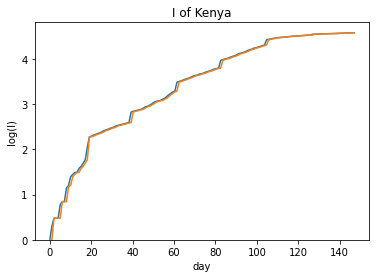

In [42]:
dat=np.linspace(0,len(It)-1,len(It)-1)
eps=0.00001

plt.plot(dat,np.log10(It_preds+eps)) #預測人數
plt.plot(dat,np.log10(It[0:len(It)-1]+eps))      #實際人數

plt.title('I of '+Country[number])
plt.xlabel('day')
plt.ylabel('log(I)')
plt.ylim((0))
print('最大誤差',np.linalg.norm((It_preds-It[0:len(It)-1]),np.inf)/N)


最大誤差 0.0022187176460926033


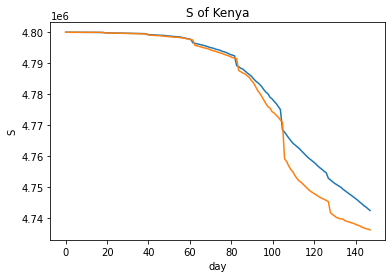

In [43]:
dat=np.linspace(0,len(St)-1,len(St)-1)
eps=0.00001

plt.plot(dat,(St_preds+eps)) #預測人數
plt.plot(dat,(St[0:len(St)-1]))      #實際人數

plt.title('S of '+Country[number])
plt.xlabel('day')
plt.ylabel('S')
#plt.ylim((0))
print('最大誤差',np.linalg.norm((St_preds-St[0:len(St)-1]),np.inf)/N)

最大誤差 0.0022490523081667335


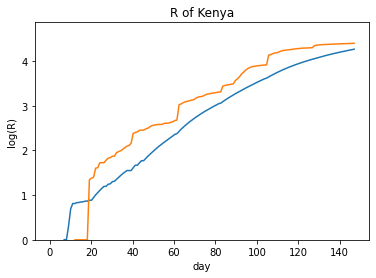

In [44]:
dat=np.linspace(0,len(Rt)-1,len(Rt)-1)
eps=0.00001

plt.plot(dat,np.log10(Rt_preds+eps)) #預測人數
plt.plot(dat,np.log10(Rt[0:len(Rt)-1]+eps))      #實際人數

plt.title('R of '+Country[number])
plt.xlabel('day')
plt.ylabel('log(R)')
plt.ylim((0))
print('最大誤差',np.linalg.norm((Rt_preds-Rt[0:len(Rt)-1]),np.inf)/N)



Text(0, 0.5, 'beta')

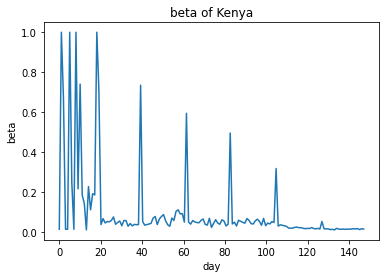

In [45]:
dat=np.linspace(0,len(BETA),len(BETA))
plt.plot(dat,(BETA)) 
plt.title('beta of '+Country[number])
plt.xlabel('day')
plt.ylabel('beta')


Text(0, 0.5, 'gamma')

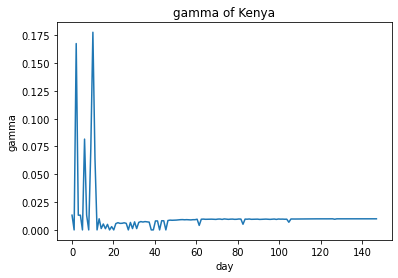

In [46]:
dat=np.linspace(0,len(Gamma),len(Gamma))
plt.plot(dat,(Gamma)) 
plt.title('gamma of '+Country[number])
plt.xlabel('day')
plt.ylabel('gamma')


Text(0, 0.5, 'mu')

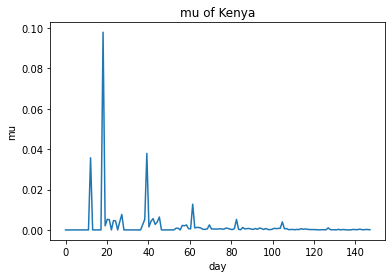

In [47]:
dat=np.linspace(0,len(Mu),len(Mu))
plt.plot(dat,(Mu)) 
plt.title('mu of '+Country[number])
plt.xlabel('day')
plt.ylabel('mu')


Text(0, 0.5, 'gamma')

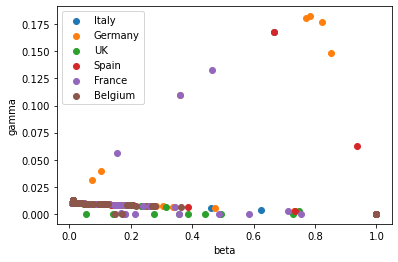

In [ ]:
plt.scatter(Italy_beta,Italy_gamma,label='Italy')
plt.scatter(Germany_beta,Germany_gamma,label='Germany')
plt.scatter(UK_beta,UK_gamma,label='UK')
plt.scatter(Spain_beta,Spain_gamma,label='Spain')

#plt.scatter(US_beta,US_gamma,label='US')
plt.scatter(France_beta,France_gamma,label='France')

#plt.scatter(China_beta,China_gamma,label='China')
plt.scatter(Belgium_beta,Belgium_gamma,label='Belgium')

plt.legend(loc=2)
plt.xlabel('beta')
plt.ylabel('gamma')

Text(0, 0.5, 'gamma')

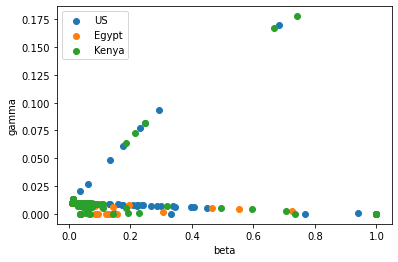

In [ ]:
plt.scatter(US_beta,US_gamma,label='US')

plt.scatter(Egypt_beta,Egypt_gamma,label='Egypt')
plt.scatter(Kenya_beta,Kenya_gamma,label='Kenya')
plt.legend(loc=2)
plt.xlabel('beta')
plt.ylabel('gamma')

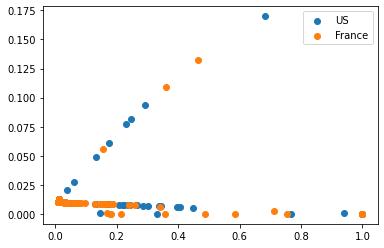

In [ ]:
#plt.scatter(Italy_beta,Italy_gamma,label='Italy')
#plt.scatter(Germany_beta,Germany_gamma,label='Germany')
#plt.scatter(UK_beta,UK_gamma,label='UK')
#plt.scatter(Spain_beta,Spain_gamma,label='Spain')

plt.scatter(US_beta,US_gamma,label='US')
plt.scatter(France_beta,France_gamma,label='France')

#plt.scatter(China_beta,China_gamma,label='China')
#plt.scatter(Belgium_beta,Belgium_gamma,label='Belgium')
plt.legend()

In [48]:

import plotly.graph_objects as go

#fig = go.Figure(data=go.Scatter(x=US_beta, y=US_gamma, mode='markers'))
#fig = go.Figure(data=go.Scatter(x=UK_beta, y=UK_gamma, mode='markers'))
fig = go.Figure()

# Add traces

fig.add_trace(go.Scatter(x=Italy_beta, y=Italy_gamma, mode='markers',name='Italy'))
fig.add_trace(go.Scatter(x=Germany_beta, y=Germany_gamma, mode='markers',name='Germany'))
fig.add_trace(go.Scatter(x=UK_beta, y=UK_gamma, mode='markers',name='UK'))
fig.add_trace(go.Scatter(x=Spain_beta, y=Spain_gamma, mode='markers',name='Spain'))
fig.add_trace(go.Scatter(x=US_beta, y=US_gamma, mode='markers',name='US'))
fig.add_trace(go.Scatter(x=France_beta, y=France_gamma, mode='markers',name='France'))
fig.add_trace(go.Scatter(x=China_beta, y=China_gamma, mode='markers',name='China'))
fig.add_trace(go.Scatter(x=Belgium_beta, y=Belgium_gamma, mode='markers',name='Belgium'))


fig.update_layout(
    #title="Plot Title",
    xaxis_title="beta",
    yaxis_title="gamma",
)


fig.show()

In [49]:

fig1 = go.Figure()

fig1.add_trace(go.Scatter(x=np.linspace(0,len(Italy_beta),len(Italy_beta)), y=Italy_beta, mode='lines+markers',name='Italy'))
fig1.add_trace(go.Scatter(x=np.linspace(0,len(Germany_beta),len(Germany_beta)), y=Germany_beta, mode='lines+markers',name='Germany'))
fig1.add_trace(go.Scatter(x=np.linspace(0,len(UK_beta),len(UK_beta)), y=UK_beta, mode='lines+markers',name='UK'))
fig1.add_trace(go.Scatter(x=np.linspace(0,len(Spain_beta),len(Spain_beta)), y=Spain_beta, mode='lines+markers',name='Spain'))
fig1.add_trace(go.Scatter(x=np.linspace(0,len(US_beta),len(US_beta)), y=US_beta, mode='lines+markers',name='US'))
fig1.add_trace(go.Scatter(x=np.linspace(0,len(France_beta),len(France_beta)), y=France_beta, mode='lines+markers',name='France'))
fig1.add_trace(go.Scatter(x=np.linspace(0,len(China_beta),len(China_beta)), y=China_beta, mode='lines+markers',name='China'))
fig1.add_trace(go.Scatter(x=np.linspace(0,len(Belgium_beta),len(Belgium_beta)), y=Belgium_beta, mode='lines+markers',name='Belgium'))



fig1.update_layout(
    #title="Plot Title",
    xaxis_title="days",
    yaxis_title="beta",
)

fig1.show()

In [50]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(x=np.linspace(0,len(Italy_gamma),len(Italy_gamma)), y=Italy_gamma, mode='lines+markers',name='Italy'))
fig2.add_trace(go.Scatter(x=np.linspace(0,len(Germany_gamma),len(Germany_gamma)), y=Germany_gamma, mode='lines+markers',name='Germany'))
fig2.add_trace(go.Scatter(x=np.linspace(0,len(UK_gamma),len(UK_gamma)), y=UK_gamma, mode='lines+markers',name='UK'))
fig2.add_trace(go.Scatter(x=np.linspace(0,len(Spain_gamma),len(Spain_gamma)), y=Spain_gamma, mode='lines+markers',name='Spain'))
fig2.add_trace(go.Scatter(x=np.linspace(0,len(US_gamma),len(US_gamma)), y=US_gamma, mode='lines+markers',name='US'))
fig2.add_trace(go.Scatter(x=np.linspace(0,len(France_gamma),len(France_gamma)), y=France_gamma, mode='lines+markers',name='France'))
fig2.add_trace(go.Scatter(x=np.linspace(0,len(China_gamma),len(China_gamma)), y=China_gamma, mode='lines+markers',name='China'))
fig2.add_trace(go.Scatter(x=np.linspace(0,len(Belgium_gamma),len(Belgium_gamma)), y=Belgium_gamma, mode='lines+markers',name='Belgium'))



fig2.update_layout(
    #title="Plot Title",
    xaxis_title="days",
    yaxis_title="gamma",
)

fig2.show()

In [51]:
fig3 = go.Figure()

fig3.add_trace(go.Scatter(x=np.linspace(0,len(Italy_mu),len(Italy_mu)), y=Italy_mu, mode='lines+markers',name='Italy'))
fig3.add_trace(go.Scatter(x=np.linspace(0,len(Germany_mu),len(Germany_mu)), y=Germany_mu, mode='lines+markers',name='Germany'))
fig3.add_trace(go.Scatter(x=np.linspace(0,len(UK_mu),len(UK_mu)), y=UK_mu, mode='lines+markers',name='UK'))
fig3.add_trace(go.Scatter(x=np.linspace(0,len(Spain_mu),len(Spain_mu)), y=Spain_mu, mode='lines+markers',name='Spain'))
fig3.add_trace(go.Scatter(x=np.linspace(0,len(US_mu),len(US_mu)), y=US_mu, mode='lines+markers',name='US'))
fig3.add_trace(go.Scatter(x=np.linspace(0,len(France_mu),len(France_mu)), y=France_mu, mode='lines+markers',name='France'))
fig3.add_trace(go.Scatter(x=np.linspace(0,len(China_mu),len(China_mu)), y=China_mu, mode='lines+markers',name='China'))
fig3.add_trace(go.Scatter(x=np.linspace(0,len(Belgium_mu),len(Belgium_mu)), y=Belgium_gamma, mode='lines+markers',name='Belgium'))



fig3.update_layout(
    #title="Plot Title",
    xaxis_title="days",
    yaxis_title="mu",
)

fig3.show()

In [55]:
fig4 = go.Figure()

# Add traces

fig4.add_trace(go.Scatter(x=Italy_mu, y=Italy_beta, mode='markers',name='Italy'))
fig4.add_trace(go.Scatter(x=Germany_mu, y=Germany_beta, mode='markers',name='Germany'))
fig4.add_trace(go.Scatter(x=UK_mu, y=UK_beta, mode='markers',name='UK'))
fig4.add_trace(go.Scatter(x=Spain_mu, y=Spain_beta, mode='markers',name='Spain'))
fig4.add_trace(go.Scatter(x=US_mu, y=US_beta, mode='markers',name='US'))
fig4.add_trace(go.Scatter(x=France_mu, y=France_beta, mode='markers',name='France'))
fig4.add_trace(go.Scatter(x=China_mu, y=China_beta, mode='markers',name='China'))
fig4.add_trace(go.Scatter(x=Belgium_mu, y=Belgium_beta, mode='markers',name='Belgium'))


fig4.update_layout(
    #title="Plot Title",
    xaxis_title="mu",
    yaxis_title="beta",
)


fig4.show()

In [54]:
mu

0.00010422631712476287